In [2]:
%matplotlib inline 
# matplotli의 Notebook 안에서 결과를 보여준다

import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,10]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.cluster import MiniBatchKMeans
import warnings # s 주의
warnings .filterwarnings('ignore')


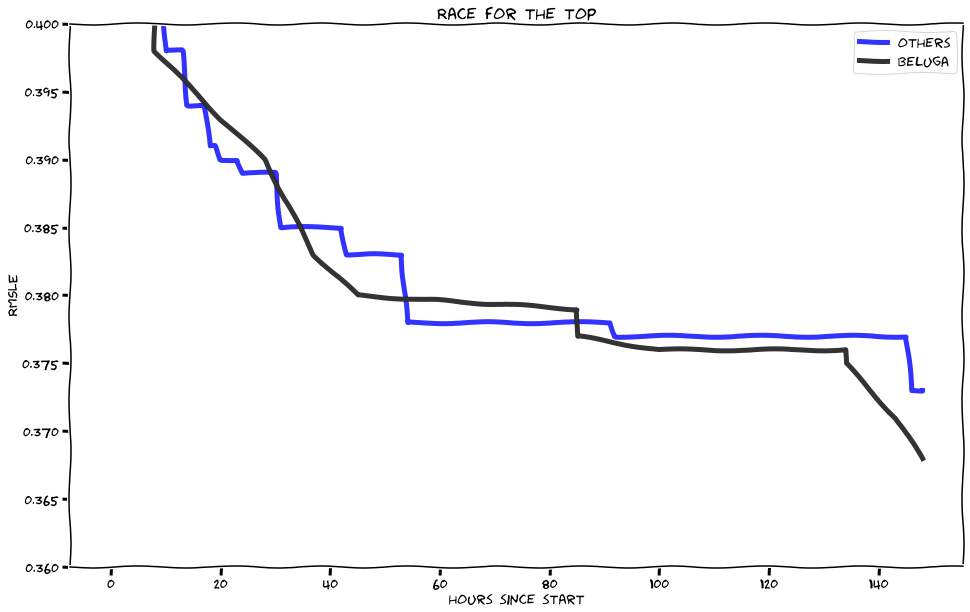

In [3]:
beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]}) 

with plt.xkcd():
  # This figure will be in XKCD-style
  fig, ax = plt.subplots()
  ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='others') # b:blue, alpha:진하기 
  ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
  ax.set_ylim(0.36, 0.4) # y range
  ax.legend(loc=0)
  ax.set_xlabel('hours since start')
  ax.set_ylabel('RMSLE') # Root min square lugar
  ax.set_title('Race for the top')
  plt.show()

In [4]:
### Data Understanding

In [5]:
np.random.seed(1989)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train=pd.read_csv('/content/drive/MyDrive/nyc-taxi-trip-duration/train.zip')
test=pd.read_csv('/content/drive/MyDrive/nyc-taxi-trip-duration/test.zip')

In [6]:
train.info()  # test에 내린 시간(dropoff), 여행기간(duration) 없음
# duration 예측하자 
# longitude(경도, 동서), latitude(위도, 남북)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
train['pickup_datetime']

0          2016-03-14 17:24:55
1          2016-06-12 00:43:35
2          2016-01-19 11:35:24
3          2016-04-06 19:32:31
4          2016-03-26 13:30:55
                  ...         
1458639    2016-04-08 13:31:04
1458640    2016-01-10 07:35:15
1458641    2016-04-22 06:57:41
1458642    2016-01-05 15:56:26
1458643    2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: object

In [8]:
print('We have {} training rows and {} training cols'.format(train.shape[0], train.shape[1]))


We have 1458644 training rows and 11 training cols


In [9]:
print('We have {} testing rows and {} testing cols'.format(test.shape[0], test.shape[1]))

We have 625134 testing rows and 9 testing cols


In [10]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops') # 독립적이다 

Id is unique.


In [11]:
print('Train and Test sets are distinct') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('oops') 
# 여기서 len은 길이를 찾아주니 2개면 길이 2를 반환
# distinct 구별된다, 별개다

Train and Test sets are distinct


In [12]:
print('don"t worry about non value') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')

don"t worry about non value


In [13]:
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()))))

The store_and_fwd_flag has only two values {'Y', 'N'}.


In [14]:
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

The store_and_fwd_flag has only two values {'Y', 'N'}.


In [15]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)  # object로 연산이 안되니 형식 변환
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)  # object로 연산이 안되니 형식 변환

In [16]:
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date  # 새로운 항목 위치시킴(만듦)_date만
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date  # 새로운 항목 위치시킴(만듦)

In [17]:
train.loc[[349,350,351]]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
349,id3252664,2,2016-06-28 07:17:36,2016-06-28 07:22:36,1,-73.967514,40.766155,-73.960526,40.771442,N,300,2016-06-28
350,id3755869,2,2016-04-24 16:48:08,2016-04-24 17:04:41,3,-73.952942,40.810188,-73.945511,40.778118,N,993,2016-04-24
351,id2440671,2,2016-02-17 17:40:25,2016-02-17 18:13:13,1,-73.863655,40.769623,-73.913223,40.872799,N,1968,2016-02-17


In [18]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) # test에는 없음(우리가 유추해야 함)

In [19]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag == 'Y') # Y,N을 되어 있던 걸 0,1로 교체


In [20]:
train.loc[train['id'] == 'id1633648'] # 특정 row를 가져올 때 쓰는 문법 
# header(column label)의 name과 column의 value를 가지고 얻어내는 방법

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.977905,40.754871,-73.952774,40.768166,1,918,2016-06-20


들으면서 치니깐 별로다, 셀 하나 듣고 적고 하자

In [21]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x:x.total_seconds())

In [22]:
duration_difference = train[np.abs(train['check_trip_duration'] - train['trip_duration']) > 1 ]  # 차이의 절댒값이 1보다 크면 

In [23]:
print(duration_difference)

Empty DataFrame
Columns: [id, vendor_id, pickup_datetime, dropoff_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag, trip_duration, pickup_date, check_trip_duration]
Index: []


In [24]:
print('Trip_duration and datetimes are OK') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('oops') 

Trip_duration and datetimes are OK


In [25]:
train['trip_duration'].max() // 3600  # 나눗셈하고 소숫점 버리고 정수 부분만
# 튀는 부분을 잡으려고

979

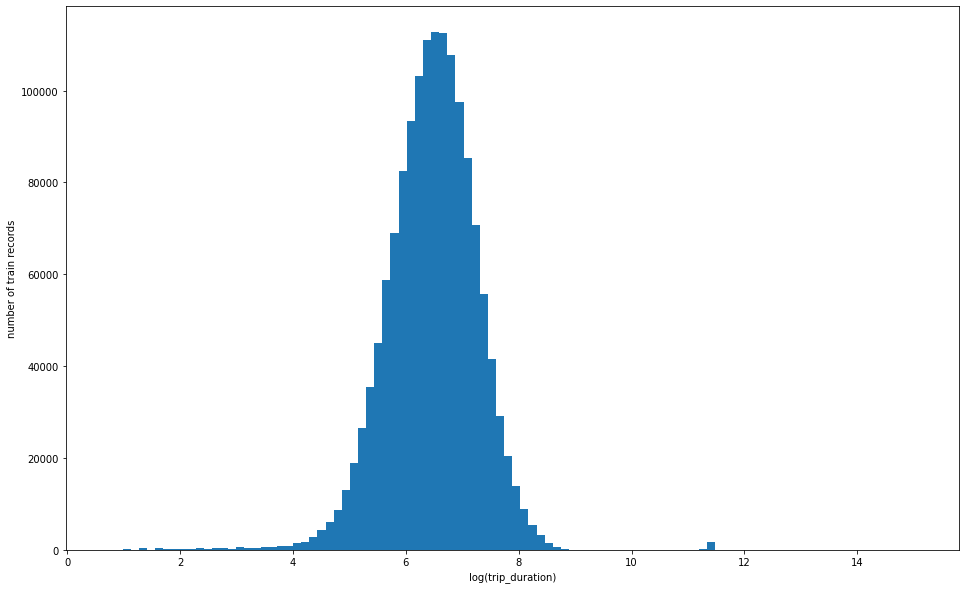

In [26]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)  # 왜 1 더하지
plt.hist(train['log_trip_duration'].values, bins=100) # bins가 뭐지
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [27]:
train.groupby('pickup_date').count()[['id']]

,id
pickup_date,
2016-01-01,7162
2016-01-02,6512
2016-01-03,6353
2016-01-04,6725
2016-01-05,7204
...,...
2016-06-26,7084
2016-06-27,7311
2016-06-28,7253


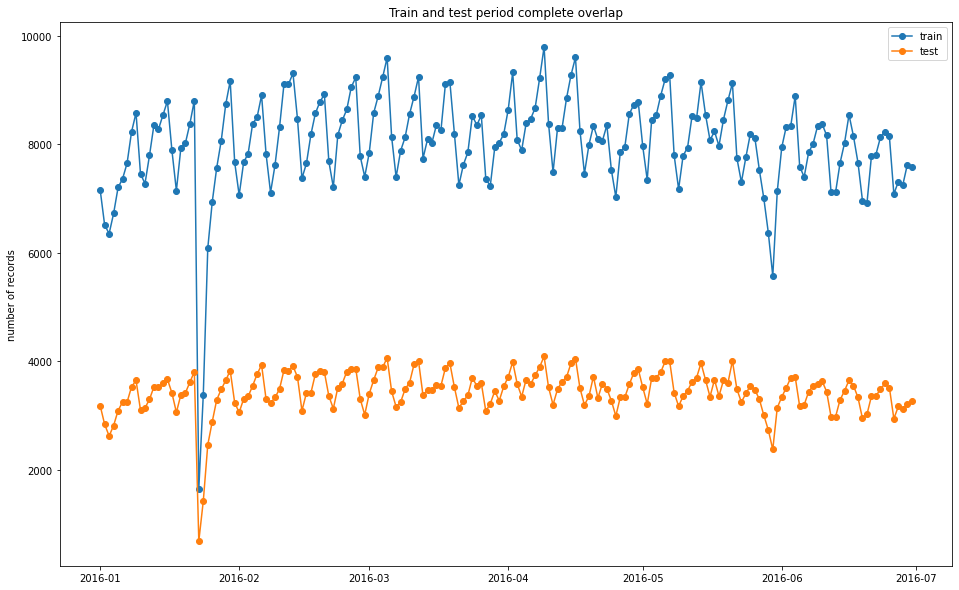

In [28]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap')
plt.legend(loc=0) 
# o은 best, 1 upper right? 등 
plt.ylabel('number of records')   
plt.show()

In [29]:
def fool(x):
  if x < 2000:
    return x

df = train.groupby('pickup_date').count()['id'].map(fool)
df

pickup_date
2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
              ..
2016-06-26   NaN
2016-06-27   NaN
2016-06-28   NaN
2016-06-29   NaN
2016-06-30   NaN
Name: id, Length: 182, dtype: float64

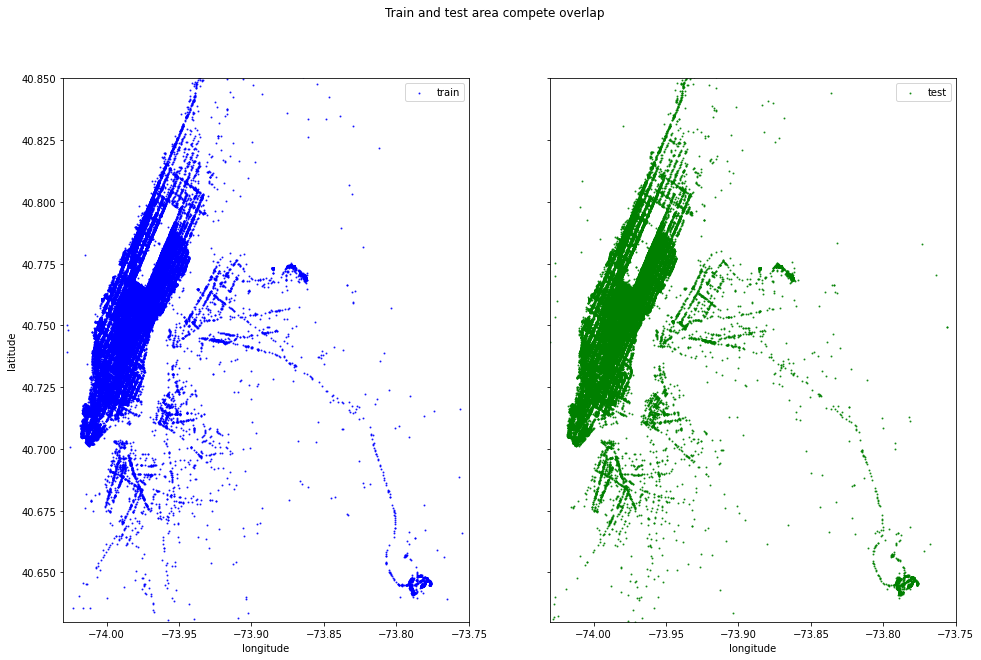

In [30]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], c='blue', s=1, label='train', alpha=0.8)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N], c='green', s=1, label='test', alpha=0.8)
# [:N] 처음부터 N 앞까지  
fig.suptitle('Train and test area compete overlap')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Feature Extraction
- PCA(Principal Cㅒmponent Analysis) : 주성분 분석
벡터 2개로 분석하는게 가장 효과적
데이터 하나 하나에 대한 분석이 아니라 여러 데이터들이 모여 하나의 분포를 이룰 때 이 분포의 주성분을 분석하는 방법

In [31]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values, 
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [32]:
pca = PCA().fit(coords)
# fit : 모델에 데이터를 학습시킨다


In [46]:
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_latitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_latitude']])[:, 1]
# transform 후 열 뽑아내기
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_latitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_latitude']])[:, 1]

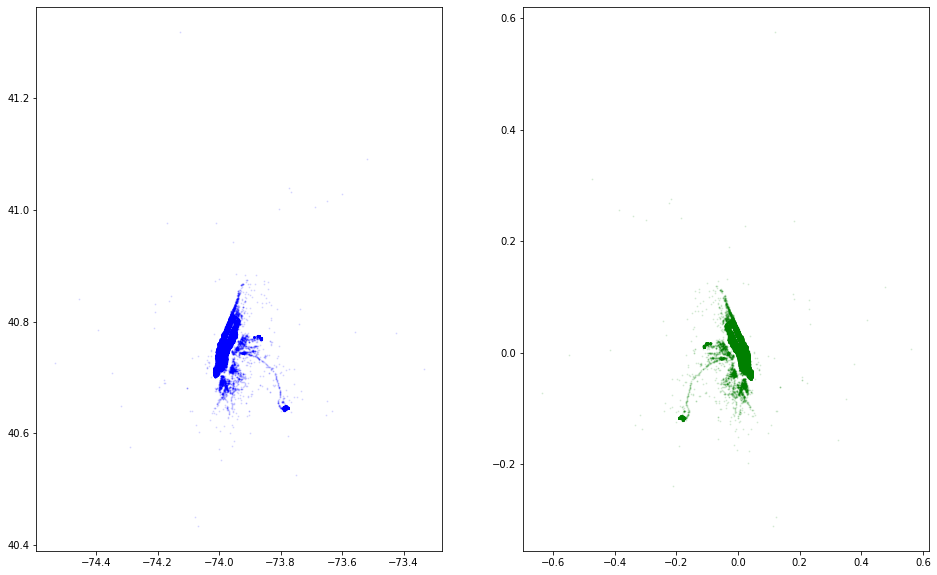

In [55]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], c='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N], c='green', s=1, alpha=0.1)
fig.suptitle(['ickup lat long coords and PCa transforemd coords')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_yalbel('pca1')
ax[0].set_ylim(city_lat_border)
ax[0].set_xlim(city_long_border)
pca_borders = pca.transform([[x, y] for x in city_long_border for y in city_lat_border])
ax[1].set_xlim(pca.borders[:])